In [31]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/BID Historical Data.csv')
# Đổi kiểu dữ liệu cột Date và đặt Index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
# Chuyển đổi các cột khác sang dạng số nếu cần thiết
df['Price'] = df['Price'].str.replace(',', '').astype(float)
# Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
df.sort_index(inplace=True)
# Chỉ sử dụng giá đóng cửa để đơn giản hóa
time_series = df['Price']
df1=df.reset_index()['Price']


In [33]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test theo tỷ lệ 8:2
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [38]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
18/18 [==============================] - 11s 257ms/step - loss: 0.0357 - val_loss: 0.0562
Epoch 2/100
18/18 [==============================] - 3s 166ms/step - loss: 0.0070 - val_loss: 0.0334
Epoch 3/100
18/18 [==============================] - 5s 258ms/step - loss: 0.0046 - val_loss: 0.0148
Epoch 4/100
18/18 [==============================] - 3s 190ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 5/100
18/18 [==============================] - 3s 168ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/100
18/18 [==============================] - 3s 167ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 7/100
18/18 [==============================] - 4s 213ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 8/100
18/18 [==============================] - 4s 232ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 9/100
18/18 [==============================] - 3s 169ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 10/100
18/18 [==============================] - 3s 166ms/step - loss: 0.0021 - val_l

In [40]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 54ms/step


In [41]:
# 11. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [42]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 49382.983175129666
Testing RMSE: 45135.529226591236


In [43]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        #print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure the length is always 100
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1


[0.92495525]
101
1 day input [0.66330944 0.65934838 0.66727051 0.66727051 0.69631832 0.69499797
 0.67783335 0.67519264 0.69895903 0.7293272  0.71876436 0.69631832
 0.7029201  0.72404578 0.71480329 0.69895903 0.71612365 0.69895903
 0.58936956 0.60125275 0.58936956 0.60389346 0.6144563  0.61049524
 0.61973772 0.63558199 0.66991122 0.65670767 0.66991122 0.66198909
 0.66198909 0.65934838 0.64614483 0.65142625 0.65406696 0.66727051
 0.68443513 0.70424045 0.69895903 0.69895903 0.6910369  0.70952187
 0.69895903 0.72008471 0.71612365 0.73856969 0.78874318 0.77950069
 0.81515028 0.79138389 0.77818034 0.7940246  0.80194673 0.80062638
 0.81779099 0.87984768 0.87852733 0.86796449 0.85476094 0.84155739
 0.85608129 0.84947952 0.84287774 0.82307241 0.81118922 0.80194673
 0.84815916 0.85212023 0.85608129 0.85608129 0.84551845 0.86532378
 0.86796449 0.87720697 0.87720697 0.93926366 0.97887432 0.96303006
 0.98679645 0.96303006 0.97623361 0.97623361 1.         0.98415574
 0.97095219 0.91285656 0.8970123 

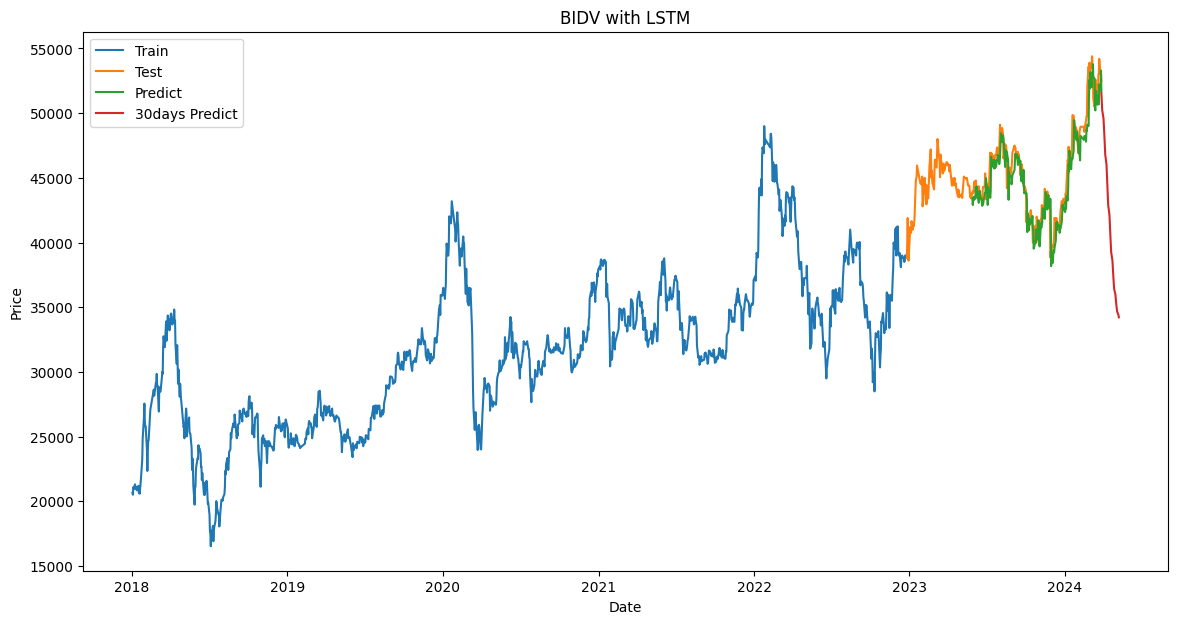

In [48]:
# 14. Vẽ hình với trục hoành là ngày và trục tung là giá
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(df.index[train_size:train_size+len(test_data)], scaler.inverse_transform(test_data), label='Test')
plt.plot(df.index[train_size+time_step+1:train_size+time_step+1+len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(df.index[-1], periods=30, freq='B')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30days Predict')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BIDV with LSTM')
plt.legend()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
18/18 [==============================] - 10s 235ms/step - loss: 0.0675 - val_loss: 0.0244
Epoch 2/100
18/18 [==============================] - 3s 173ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 3/100
18/18 [==============================] - 4s 232ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/100
18/18 [==============================] - 4s 214ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 5/100
18/18 [==============================] - 3s 164ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 6/100
18/18 [==============================] - 3s 164ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 7/100
18/18 [==============================] - 3s 185ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 8/100
18/18 [==============================] - 5s 262ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/100
18/18 [==============================] - 3s 166ms/

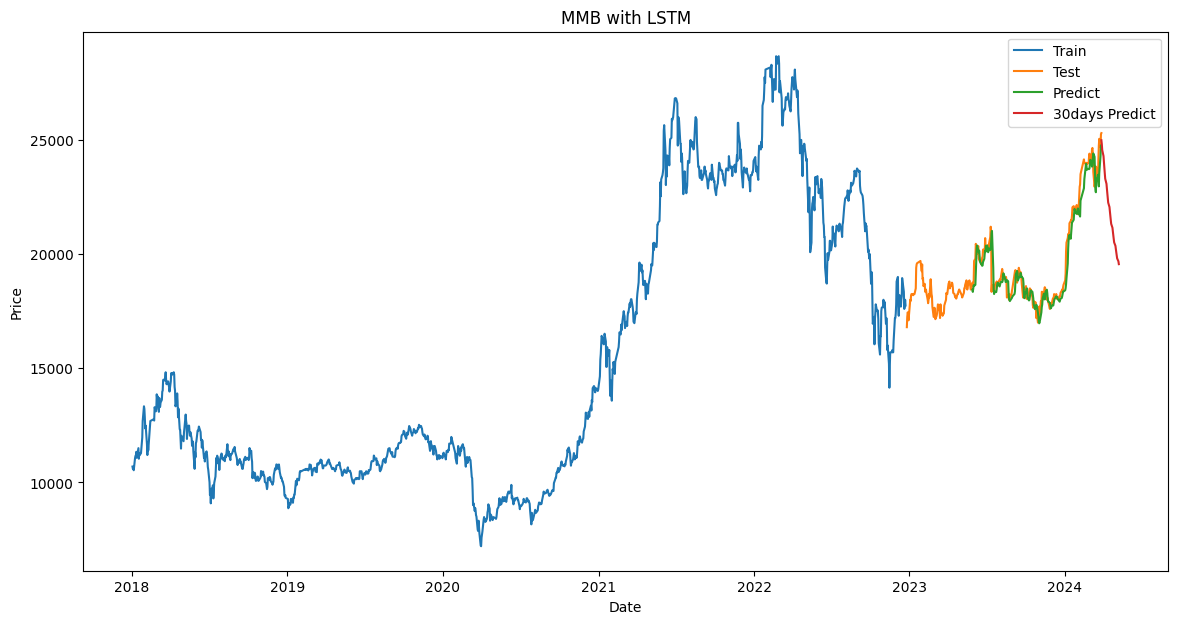

In [49]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/MBB Historical Data.csv')

# Đổi kiểu dữ liệu cột Date và đặt Index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Chuyển đổi các cột khác sang dạng số nếu cần thiết
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
df.sort_index(inplace=True)

# Chỉ sử dụng giá đóng cửa để đơn giản hóa
time_series = df['Price']
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test theo tỷ lệ 8:2
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[-100:])  # Ensure the length is always 100
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# 14. Vẽ hình với trục hoành là ngày và trục tung là giá
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(df.index[train_size:train_size+len(test_data)], scaler.inverse_transform(test_data), label='Test')
plt.plot(df.index[train_size+time_step+1:train_size+time_step+1+len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(df.index[-1], periods=30, freq='B')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30days Predict')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MMB with LSTM')
plt.legend()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
18/18 [==============================] - 10s 306ms/step - loss: 0.0426 - val_loss: 0.0463
Epoch 2/100
18/18 [==============================] - 4s 245ms/step - loss: 0.0059 - val_loss: 0.0181
Epoch 3/100
18/18 [==============================] - 3s 170ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 4/100
18/18 [==============================] - 3s 171ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 5/100
18/18 [==============================] - 3s 174ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 6/100
18/18 [==============================] - 5s 277ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 7/100
18/18 [==============================] - 3s 172ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 8/100
18/18 [==============================] - 3s 172ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 9/100
18/18 [==============================] - 3s 172ms/

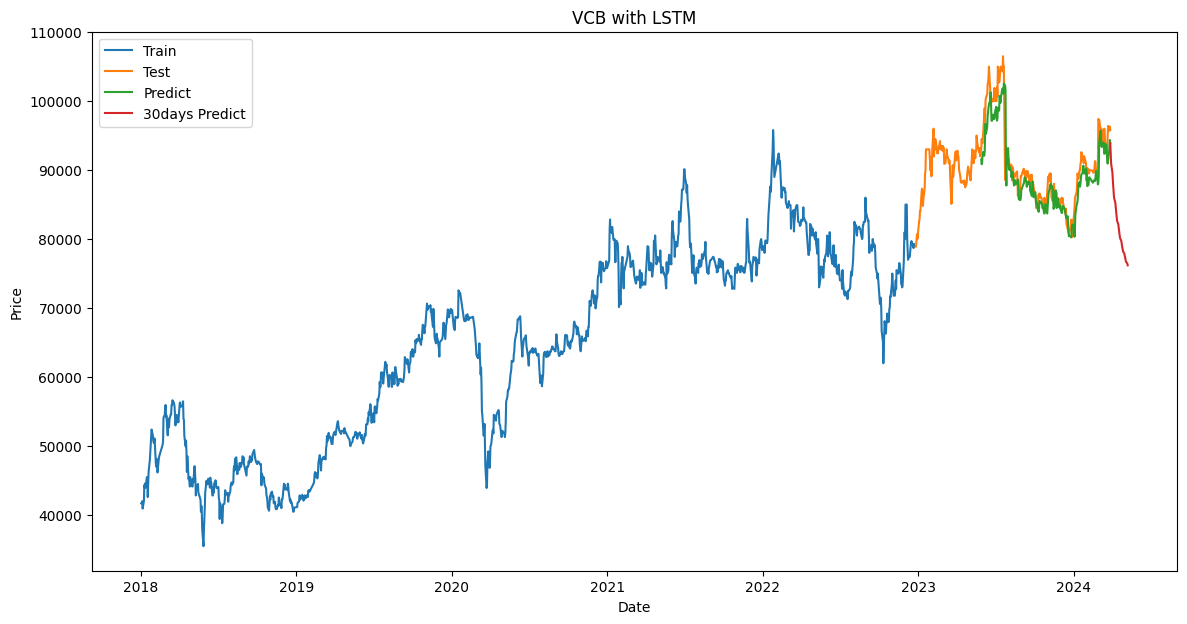

In [50]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/VCB Historical Data.csv')

# Đổi kiểu dữ liệu cột Date và đặt Index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Chuyển đổi các cột khác sang dạng số nếu cần thiết
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
df.sort_index(inplace=True)

# Chỉ sử dụng giá đóng cửa để đơn giản hóa
time_series = df['Price']
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test theo tỷ lệ 8:2
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   # i=0, X=0,1,2,3-----99   Y=100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

# 11. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 30):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[-100:])  # Ensure the length is always 100
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

# 14. Vẽ hình với trục hoành là ngày và trục tung là giá
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(df.index[train_size:train_size+len(test_data)], scaler.inverse_transform(test_data), label='Test')
plt.plot(df.index[train_size+time_step+1:train_size+time_step+1+len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(df.index[-1], periods=30, freq='B')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30days Predict')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('VCB with LSTM')
plt.legend()
plt.show()